In [143]:
import torch
from models import ModelGenerator
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [144]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [145]:
model_cam1 = ModelGenerator.get_dl_model("squeezenet", True, device)
model_cam1.load_state_dict(torch.load('checkpoints/cam1/CP_epoch4653.pth', map_location=device))

model_cam2 = ModelGenerator.get_dl_model("squeezenet", True, device)
model_cam2.load_state_dict(torch.load('checkpoints/cam2/CP_epoch4438.pth', map_location=device))

model_cam3 = ModelGenerator.get_dl_model("squeezenet", True, device)
model_cam3.load_state_dict(torch.load('checkpoints/cam3/CP_epoch4910.pth', map_location=device))

model_cam4 = ModelGenerator.get_dl_model("squeezenet", True, device)
model_cam4.load_state_dict(torch.load('checkpoints/cam4/CP_epoch2884.pth', map_location=device))

<All keys matched successfully>

In [146]:
def get_specific_frame(video_path, frame_number):
    cap = cv2.VideoCapture(video_path)
    
    # Verifica se o vídeo está aberto corretamente
    if not cap.isOpened():
        print("Erro ao abrir o vídeo.")
        return
    
    # Define o número do frame desejado
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    # Lê o frame especificado
    ret, frame = cap.read()
    
    # Libera o vídeo
    cap.release()
    
    if ret:
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        print(f"Erro ao ler o frame {frame_number}.")
        return None

In [147]:
def crop_img(img, init_point, end_point):
    return img[init_point[0]:end_point[0], init_point[1]:end_point[1], :]

def preprocess( pil_img):

    img_nd = np.array(cv2.resize(pil_img, (256, 256)))

    if len(img_nd.shape) == 2:
        img_nd = np.expand_dims(img_nd, axis=2)

    # HWC to CHW
    img_trans = img_nd.transpose((2, 0, 1))
        
    if img_trans.max() > 1:
        img_trans = img_trans / 255
        
    
        
    return torch.from_numpy(img_trans).type(torch.FloatTensor).unsqueeze(0).cuda()


def predict_points(model, img):
    
    data = preprocess(img)
    points = model(data)
    points = [int(p*256) for p in points.tolist()[0]]
    points = [(points[i], points[i+1]) for i in range(0,len(points),2)]
    
    return points


def plot_points_on_image(img, points_list):
    
    # Cria uma cópia da imagem para desenhar os pontos
    img_copy = img.copy()
    
    # Itera sobre a lista de pontos e desenha cada um deles na imagem
    for point in points_list:
        x, y = point
        cv2.circle(img_copy, (x, y), 3, (0, 255, 0), -1)  # Desenha um círculo verde de raio 3 nos pontos
    
    return img_copy

def joint_points(img, points):
    # Cria uma cópia da imagem para desenhar as linhas
    img_copy = np.zeros_like(img)
    
    # Itera sobre os pontos para desenhar as linhas
    for i in range(len(points) - 1):
        pt1 = points[i]
        pt2 = points[i + 1]
        cv2.line(img_copy, pt1, pt2, (1, 1, 1), 10)  # Desenha uma linha vermelha entre os pontos
    
    return img_copy

def apply_segmentation_mask(image, mask):
    # Convertendo a imagem e a máscara para arrays NumPy para operações matriciais
    image_np = np.array(image)
    mask_np = np.array(mask)

    # Aplicando a máscara na imagem
    masked_image = np.where(mask_np == 1, image_np, 0)

    return masked_image

In [148]:
VIDEO_PATH = "D:/Doutorado/MIRC dataset/original_data/original_data/single-person/subject2/activity1/routine05.mkv"

In [149]:
frame = get_specific_frame(VIDEO_PATH, 90)

In [150]:
imgs = [
            crop_img(frame, (0, 0), (720, 1280)),
            crop_img(frame, (0, 1320), (720, 2600)),
            crop_img(frame, (780, 0), (1500, 1280)),
            crop_img(frame, (780, 1320), (1500, 2600))
        ]

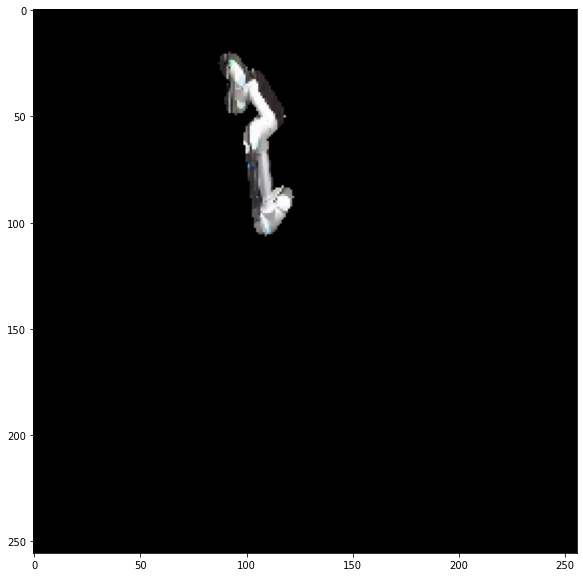

In [151]:
points = predict_points(model_cam1, imgs[0])
ploted = plot_points_on_image(cv2.resize(imgs[0], (256, 256)), points)
seg_mask = joint_points(cv2.resize(imgs[0], (256, 256)), points)
plt.figure(figsize=(10, 10))
plt.imshow( apply_segmentation_mask( cv2.resize(imgs[0], (256, 256)), seg_mask)) 

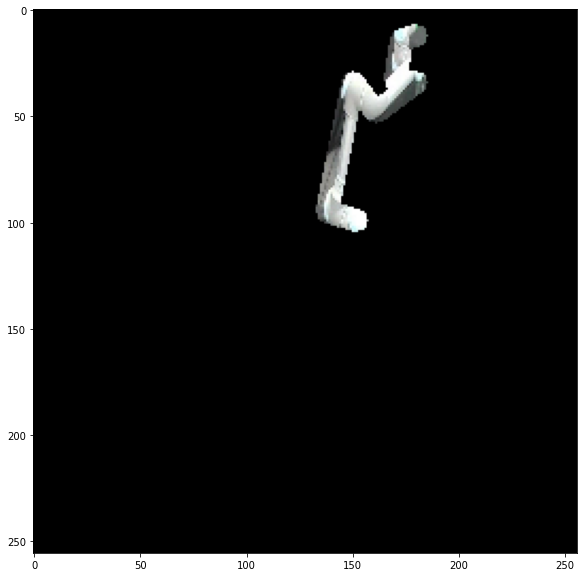

In [152]:
points = predict_points(model_cam2, imgs[1])
ploted = plot_points_on_image(cv2.resize(imgs[1], (256, 256)), points)
seg_mask = joint_points(cv2.resize(imgs[1], (256, 256)), points)
plt.figure(figsize=(10, 10))
plt.imshow( apply_segmentation_mask( cv2.resize(imgs[1], (256, 256)), seg_mask)) 

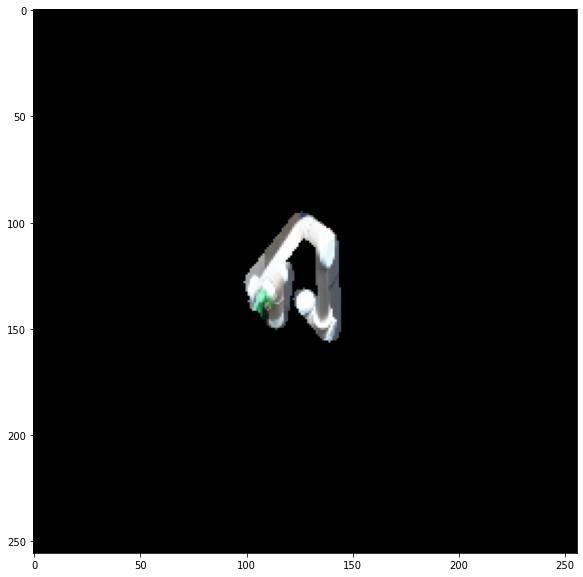

In [153]:
points = predict_points(model_cam3, imgs[2])
ploted = plot_points_on_image(cv2.resize(imgs[2], (256, 256)), points)
seg_mask = joint_points(cv2.resize(imgs[2], (256, 256)), points)
plt.figure(figsize=(10, 10))
plt.imshow( apply_segmentation_mask( cv2.resize(imgs[2], (256, 256)), seg_mask)) 

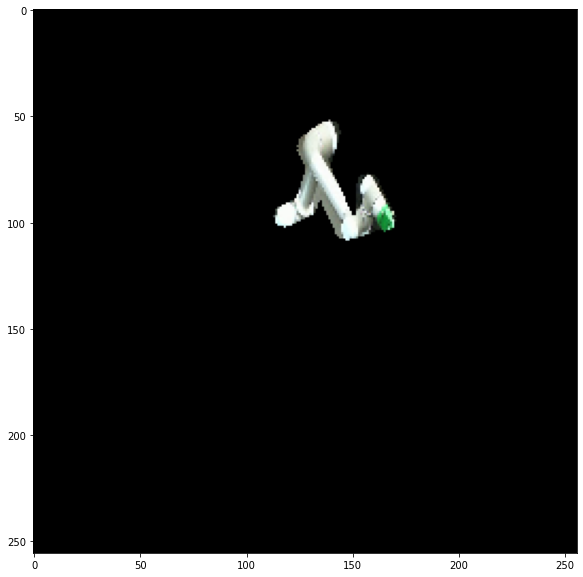

In [154]:
points = predict_points(model_cam4, imgs[3])
ploted = plot_points_on_image(cv2.resize(imgs[3], (256, 256)), points)
seg_mask = joint_points(cv2.resize(imgs[3], (256, 256)), points)
plt.figure(figsize=(10, 10))
plt.imshow( apply_segmentation_mask( cv2.resize(imgs[3], (256, 256)), seg_mask)) 